In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, precision_recall_curve,confusion_matrix,auc,roc_auc_score,RocCurveDisplay, roc_curve,PrecisionRecallDisplay

import tensorflow as tf
from keras import regularizers
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, BatchNormalization,Dropout,Dense,Flatten,Conv1D


import warnings
warnings.filterwarnings('ignore')

## read data

In [2]:
df = pd.read_csv('credit_card.txt')

In [3]:
df_origin = df.copy()

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
target = 'Class'

## EDA

In [6]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

Text(0, 0.5, '')

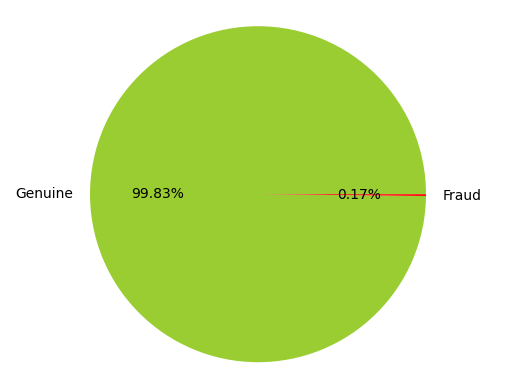

In [8]:
fig, ax = plt.subplots(1, 1)
ax.pie(df.Class.value_counts(),autopct='%1.2f%%', labels=['Genuine','Fraud'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

very unbalanced dataset - 0.17% of fraud

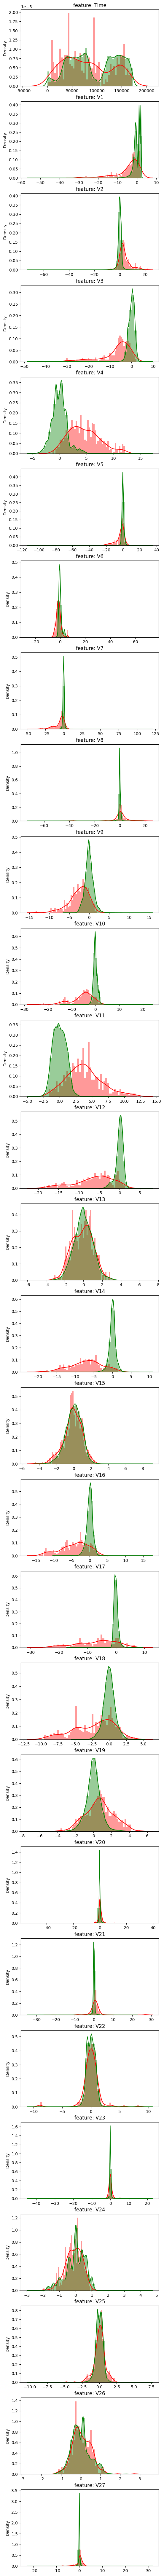

In [9]:
# check correlations of 25 components
gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(df[df.iloc[:,0:28].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(df[col][df.Class == 1], bins=50, color='r')
    sns.distplot(df[col][df.Class == 0], bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show()

In [10]:
# drop columns where fraud class almost have no differences from non-fraud
df = df.drop(['V14','V16','V21','V23','V24','V26'],axis=1)

In [11]:
df = df.drop(['Time'],axis=1)

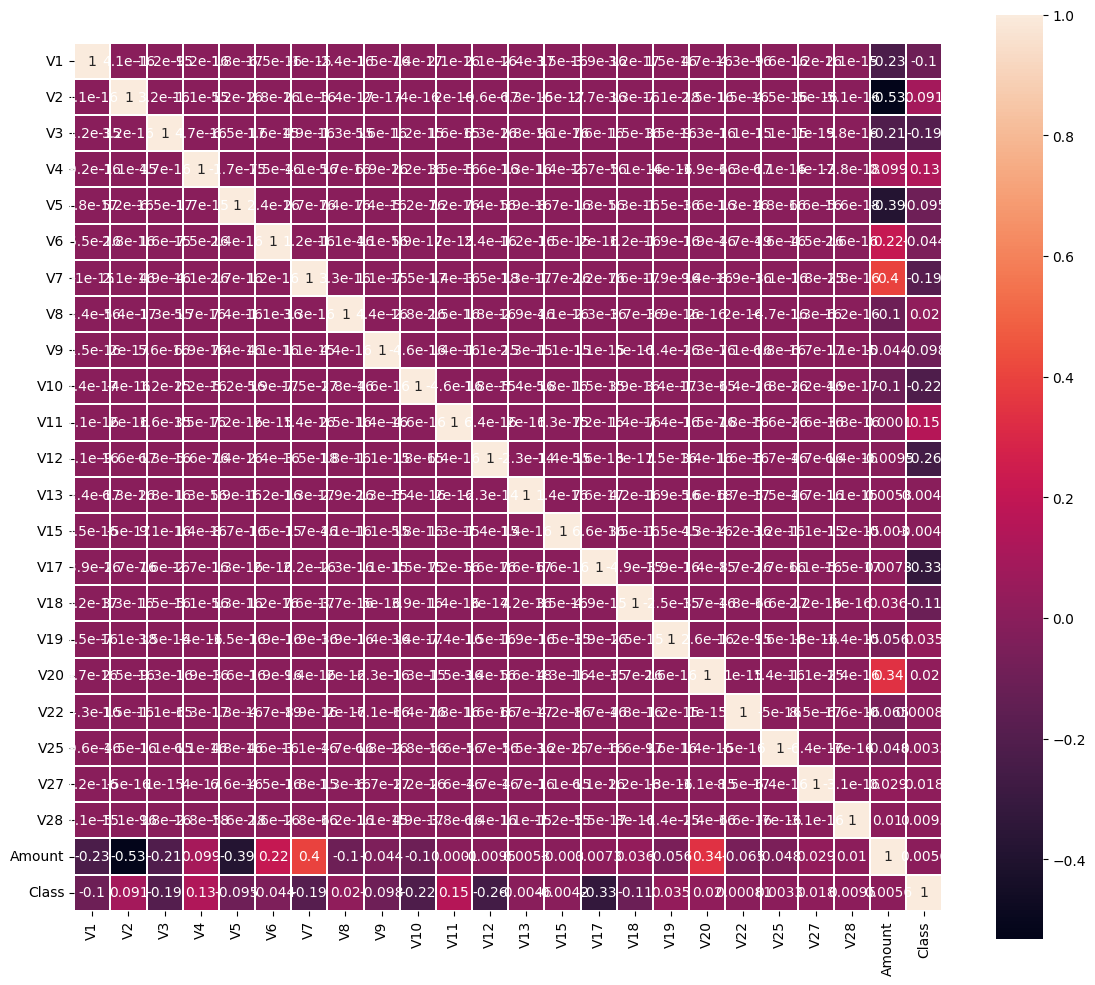

In [12]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True,linecolor='white', annot=True)
plt.show()

In [13]:
border = int(len(df)*0.9)
train = df[:border]
test = df[border:]

## create an underfitted balanced dataset

In [14]:
normal = train[train.Class == 0]
fraud = train[train.Class == 1]

In [15]:
normal.Amount.describe()

count    255856.000000
mean         90.356641
std         250.682668
min           0.000000
25%           5.990000
50%          22.985000
75%          79.292500
max       19656.530000
Name: Amount, dtype: float64

In [16]:
fraud.Amount.describe()

count     470.000000
mean      122.636404
std       260.193766
min         0.000000
25%         1.000000
50%         8.770000
75%       104.615000
max      2125.870000
Name: Amount, dtype: float64

In [17]:
normal_sample = normal.sample(n=len(fraud))

In [18]:
df_balanced = pd.concat([normal_sample,fraud])
df_balanced = df_balanced.reset_index(drop=True)

In [19]:
df_balanced.shape

(940, 24)

## splitting into features and targets

In [20]:
def split(df):
    X = df.drop(columns='Class', axis=1)
    y = df['Class']
    print(X.shape, y.shape)
    return X,y

#### split data for simple dataset

In [21]:
X_train_, y_train_ = split(train)
X_test_, y_test_ = split(test)

(256326, 23) (256326,)
(28481, 23) (28481,)


#### split training data for underfitted dataset

In [22]:
X_train_under, y_train_under = split(df_balanced)

(940, 23) (940,)


#### split training data for overfitted dataset

In [23]:
sm = SMOTE()
X_over = train.drop(columns=target, axis=1)
y_over = train[target]
X_train_over, y_train_over = sm.fit_resample(X_over,y_over)
print(X_train_over.shape)

(511712, 23)


#### functions for print and plot metrics

In [24]:
def print_metrix(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))    

In [25]:
def plot_metrics(y_test, y_pred_prob):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

## 1. Naive Bayes Classifier

In [26]:
bayes = GaussianNB()

In [27]:
bayes.fit(X_train_,y_train_)

GaussianNB()

In [28]:
y_pred_ = bayes.predict(X_test_)
y_pred_prob_ = bayes.predict_proba(X_test_)[:,1]

In [29]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[27911   548]
 [    6    16]]
recall score:  0.7272727272727273
precision score:  0.028368794326241134
f1 score:  0.05460750853242321
accuracy score:  0.9805484357993048
ROC AUC: 0.9429809710300944


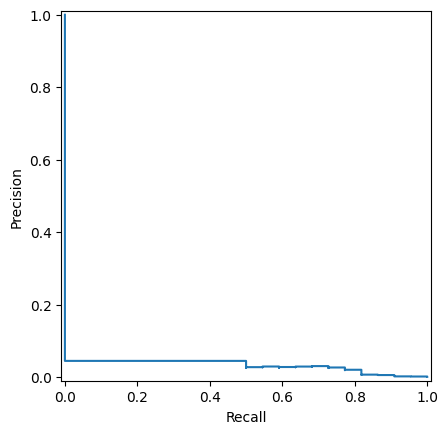

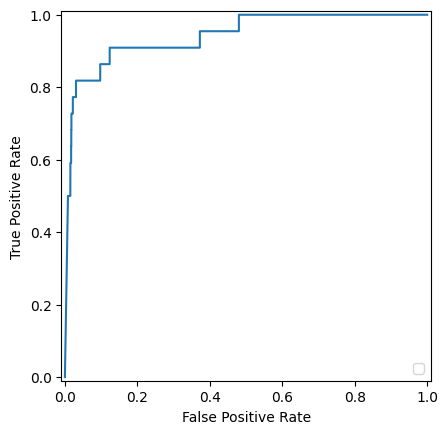

In [30]:
plot_metrics(y_test_, y_pred_prob_)

In [31]:
bayes.fit(X_train_under,y_train_under)

GaussianNB()

In [32]:
y_pred_under = bayes.predict(X_test_)
y_pred_prob_under = bayes.predict_proba(X_test_)[:,1]

In [33]:
print_metrix(y_test_,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[27545   914]
 [    5    17]]
recall score:  0.7727272727272727
precision score:  0.018259935553168637
f1 score:  0.035676810073452254
accuracy score:  0.9677328745479442
ROC AUC: 0.9283139380735923


In [34]:
bayes.fit(X_train_over,y_train_over)

GaussianNB()

In [35]:
y_pred_over = bayes.predict(X_test_)
y_pred_prob_over = bayes.predict_proba(X_test_)[:,1]

In [36]:
print_metrix(y_test_,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[27791   668]
 [    5    17]]
recall score:  0.7727272727272727
precision score:  0.024817518248175182
f1 score:  0.04809052333804809
accuracy score:  0.9763702117200941
ROC AUC: 0.9479658136585647


##### Naive Bayes performed bad on all three samples

## 2. Logistic Regression

In [37]:
lr = LogisticRegression()

In [38]:
lr.fit(X_train_,y_train_)

LogisticRegression()

In [39]:
y_pred = lr.predict(X_test_)
y_pred_prob = lr.predict_proba(X_test_)[:,1]

In [40]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[27911   548]
 [    6    16]]
recall score:  0.7272727272727273
precision score:  0.028368794326241134
f1 score:  0.05460750853242321
accuracy score:  0.9805484357993048
ROC AUC: 0.9429809710300944


In [41]:
lr.fit(X_train_under, y_train_under)

LogisticRegression()

In [42]:
y_pred_under = lr.predict(X_test_)
y_pred_prob_under = lr.predict_proba(X_test_)[:,1]

In [43]:
print_metrix(y_test_,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[27715   744]
 [    3    19]]
recall score:  0.8636363636363636
precision score:  0.02490170380078637
f1 score:  0.048407643312101914
accuracy score:  0.973771988343106
ROC AUC: 0.9504183051215624


In [44]:
lr.fit(X_train_over, y_train_over)

LogisticRegression()

In [45]:
y_pred_over = lr.predict(X_test_)
y_pred_prob_over = lr.predict_proba(X_test_)[:,1]

In [46]:
print_metrix(y_test_,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[27971   488]
 [    4    18]]
recall score:  0.8181818181818182
precision score:  0.03557312252964427
f1 score:  0.06818181818181818
accuracy score:  0.9827253256557003
ROC AUC: 0.953029717392485


##### Logistic regression also performed bad on all three samples

### 3. Random Forest

In [47]:
rf = RandomForestClassifier()

In [48]:
rf.fit(X_train_,y_train_)

RandomForestClassifier()

In [49]:
y_pred_ = rf.predict(X_test_)
y_pred_prob_ = rf.predict_proba(X_test_)[:,1]

In [50]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[28455     4]
 [    9    13]]
recall score:  0.5909090909090909
precision score:  0.7647058823529411
f1 score:  0.6666666666666666
accuracy score:  0.9995435553526912
ROC AUC: 0.8833888624464541


In [51]:
rf.fit(X_train_under,y_train_under)

RandomForestClassifier()

In [52]:
y_pred_under = rf.predict(X_test_)
y_pred_prob_under = rf.predict_proba(X_test_)[:,1]

In [53]:
print_metrix(y_test_,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[27977   482]
 [    4    18]]
recall score:  0.8181818181818182
precision score:  0.036
f1 score:  0.06896551724137931
accuracy score:  0.9829359924159966
ROC AUC: 0.9624875019565627


In [54]:
rf.fit(X_train_over,y_train_over)

RandomForestClassifier()

In [55]:
y_pred_over = rf.predict(X_test_)
y_pred_prob_over = rf.predict_proba(X_test_)[:,1]

In [56]:
print_metrix(y_test_,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[28451     8]
 [    6    16]]
recall score:  0.7272727272727273
precision score:  0.6666666666666666
f1 score:  0.6956521739130435
accuracy score:  0.9995084442259752
ROC AUC: 0.919779331670122


In [57]:
rf.feature_importances_

array([0.02339115, 0.04093712, 0.0604212 , 0.11749248, 0.00857202,
       0.01575074, 0.03474796, 0.0125765 , 0.01928327, 0.17467167,
       0.10949045, 0.14970833, 0.00714863, 0.00619728, 0.11460846,
       0.02466815, 0.01121784, 0.00816112, 0.0050866 , 0.00599789,
       0.01643872, 0.00868088, 0.02475155])

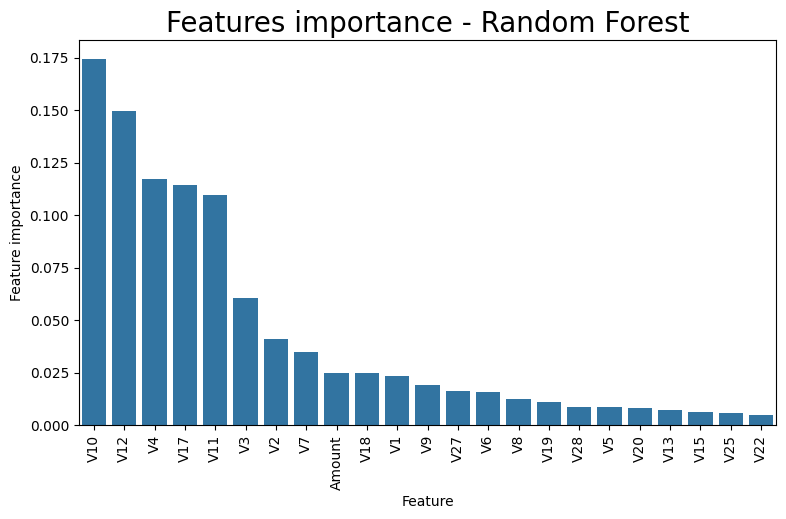

In [58]:
features = df.columns.drop(target)

plt.figure(figsize = (9,5))

feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)

g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Features importance - Random Forest',fontsize=20)
plt.show() 

##### overfitted sample have the best performance at random forest model

## 4. Boosting
#### 4.1 AdaBoost

In [59]:
ada = AdaBoostClassifier(random_state=2,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                         n_estimators=100)

In [60]:
ada.fit(X_train_, y_train_)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2)

In [61]:
y_pred_ = ada.predict(X_test_)
y_pred_prob_ = ada.predict_proba(X_test_)[:,1]

In [62]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[28453     6]
 [   11    11]]
recall score:  0.5
precision score:  0.6470588235294118
f1 score:  0.5641025641025641
accuracy score:  0.999403110845827
ROC AUC: 0.9116583985254705


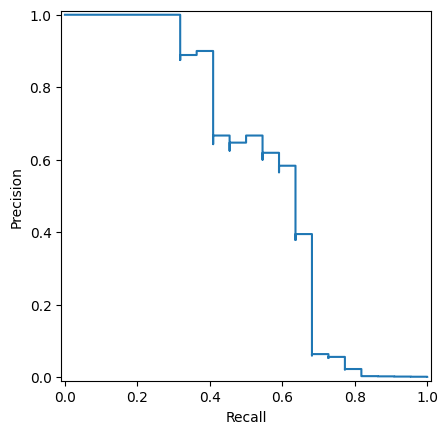

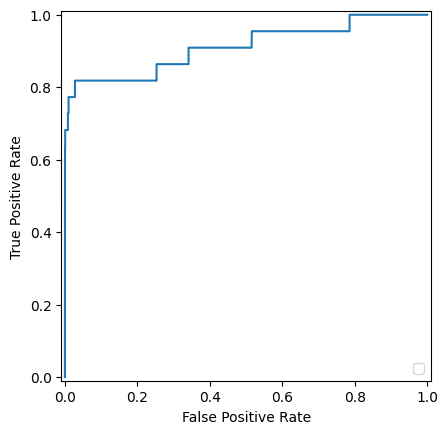

In [63]:
plot_metrics(y_test_, y_pred_prob_)

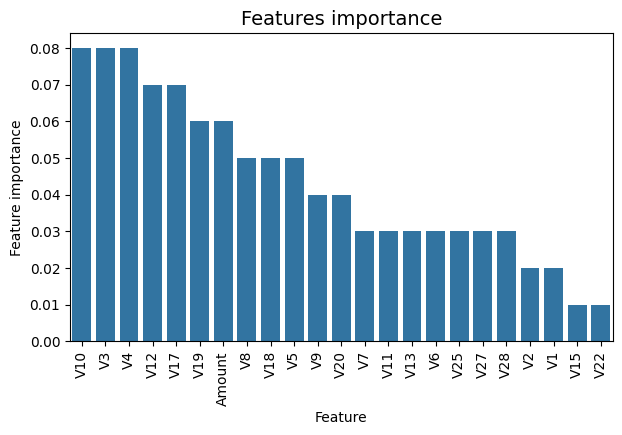

In [64]:
tmp = pd.DataFrame({'Feature': features, 'Feature importance': ada.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [65]:
ada.fit(X_train_under, y_train_under)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2)

In [66]:
y_pred_under = ada.predict(X_test_)
y_pred_prob_under = ada.predict_proba(X_test_)[:,1]

In [67]:
print_metrix(y_test_,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[27081  1378]
 [    4    18]]
recall score:  0.8181818181818182
precision score:  0.012893982808022923
f1 score:  0.02538787023977433
accuracy score:  0.9514764228784102
ROC AUC: 0.9312966979610222


In [68]:
ada.fit(X_train_over, y_train_over)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2)

In [69]:
y_pred_over = ada.predict(X_test_)
y_pred_prob_over = ada.predict_proba(X_test_)[:,1]

In [70]:
print_metrix(y_test_,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[28132   327]
 [    4    18]]
recall score:  0.8181818181818182
precision score:  0.05217391304347826
f1 score:  0.09809264305177112
accuracy score:  0.9883782170569854
ROC AUC: 0.9002552316091093


##### the results are similar to random forest, but a little worse

#### 4.2 CatBoost

In [71]:
ctb = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = 2,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=100)

In [72]:
ctb.fit(X_train_, y_train_)

0:	total: 1.36s	remaining: 11m 19s
50:	total: 33s	remaining: 4m 50s
100:	total: 1m 2s	remaining: 4m 8s
150:	total: 1m 39s	remaining: 3m 50s
200:	total: 2m 15s	remaining: 3m 21s
250:	total: 2m 48s	remaining: 2m 47s
300:	total: 3m 17s	remaining: 2m 10s
350:	total: 3m 50s	remaining: 1m 37s
400:	total: 4m 18s	remaining: 1m 3s
450:	total: 4m 46s	remaining: 31.2s
499:	total: 5m 15s	remaining: 0us


In [73]:
y_pred_ = ctb.predict(X_test_)
y_pred_prob_ = ctb.predict_proba(X_test_)[:,1]

In [74]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[28455     4]
 [    9    13]]
recall score:  0.5909090909090909
precision score:  0.7647058823529411
f1 score:  0.6666666666666666
accuracy score:  0.9995435553526912
ROC AUC: 0.9569077045446559


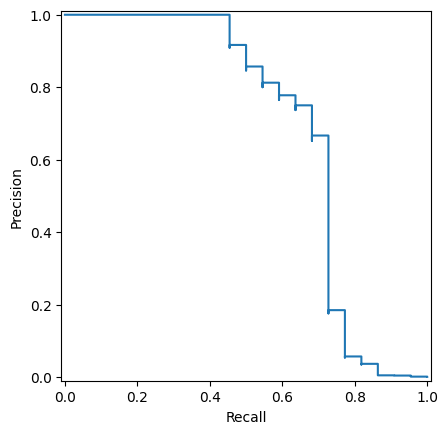

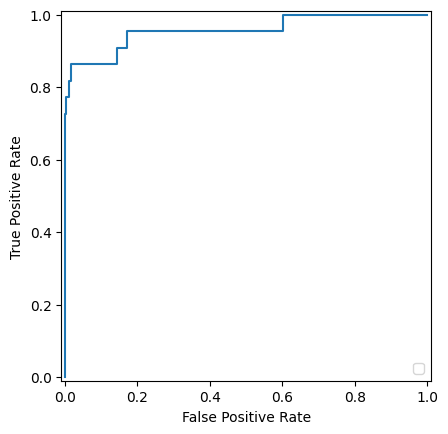

In [75]:
plot_metrics(y_test_, y_pred_prob_)

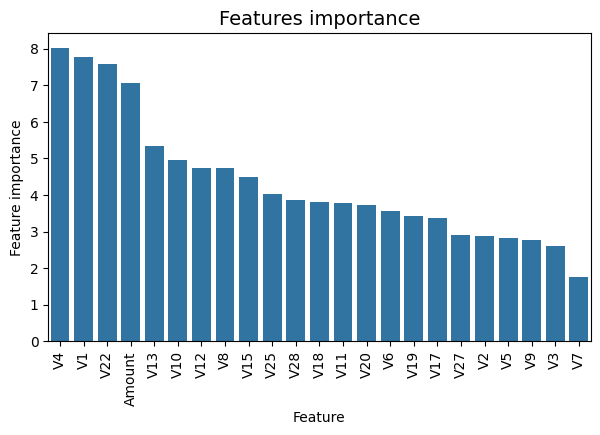

In [76]:
tmp = pd.DataFrame({'Feature': features, 'Feature importance': ctb.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

In [77]:
ctb.fit(X_train_under, y_train_under)

0:	total: 318ms	remaining: 2m 38s
50:	total: 17.6s	remaining: 2m 34s
100:	total: 35.9s	remaining: 2m 21s
150:	total: 54s	remaining: 2m 4s
200:	total: 1m 12s	remaining: 1m 48s
250:	total: 1m 31s	remaining: 1m 30s
300:	total: 1m 49s	remaining: 1m 12s
350:	total: 2m 10s	remaining: 55.3s
400:	total: 2m 30s	remaining: 37.1s
450:	total: 2m 50s	remaining: 18.5s
499:	total: 3m 9s	remaining: 0us


In [78]:
y_pred_under = ctb.predict(X_test_)
y_pred_prob_under = ctb.predict_proba(X_test_)[:,1]

In [79]:
print_metrix(y_test_,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[28165   294]
 [    5    17]]
recall score:  0.7727272727272727
precision score:  0.05466237942122187
f1 score:  0.1021021021021021
accuracy score:  0.9895017731118991
ROC AUC: 0.9420410223319673


In [80]:
ctb.fit(X_train_over, y_train_over)

0:	total: 893ms	remaining: 7m 25s
50:	total: 41.9s	remaining: 6m 8s
100:	total: 1m 23s	remaining: 5m 31s
150:	total: 2m 2s	remaining: 4m 42s
200:	total: 2m 41s	remaining: 3m 59s
250:	total: 3m 19s	remaining: 3m 17s
300:	total: 3m 57s	remaining: 2m 36s
350:	total: 4m 35s	remaining: 1m 56s
400:	total: 5m 12s	remaining: 1m 17s
450:	total: 5m 48s	remaining: 37.9s
499:	total: 6m 23s	remaining: 0us


In [81]:
y_pred_over = ctb.predict(X_test_)
y_pred_prob_over = ctb.predict_proba(X_test_)[:,1]

In [82]:
print_metrix(y_test_,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[28439    20]
 [    6    16]]
recall score:  0.7272727272727273
precision score:  0.4444444444444444
f1 score:  0.5517241379310345
accuracy score:  0.9990871107053826
ROC AUC: 0.9413638120549818


##### catboost with overfitting shows the best result so far. recall is more important metric for us than precision, because it is better to check fraud once more than to miss it

## 5. CNN

In [83]:
X_train_scale = MinMaxScaler().fit_transform(np.array(X_train_))
X_test_scale = MinMaxScaler().fit_transform(np.array(X_test_))

In [84]:
X_under_scale = MinMaxScaler().fit_transform(np.array(X_train_under))
X_over_scale = MinMaxScaler().fit_transform(np.array(X_train_over))

In [85]:
model=Sequential()
model.add(Conv1D(32,2,activation='relu',input_shape=(23,1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,2,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [86]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 22, 32)              │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 22, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 21, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1344)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          86,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,785 (354.63 KB)

 Trainable params: 90,593 (353.88 KB)

 Non-trainable params: 192 (768.00 B)

In [87]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy','precision','recall'])

In [88]:
epochs = 10

In [89]:
history = model.fit(X_train_scale,y_train_,epochs=epochs,validation_data=(X_test_scale,y_test_))

Epoch 1/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 72s 8ms/step - accuracy: 0.9949 - loss: 0.0169 - precision: 0.3320 - recall: 0.3302 - val_accuracy: 0.9986 - val_loss: 0.0059 - val_precision: 0.3200 - val_recall: 0.7273
Epoch 2/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 70s 9ms/step - accuracy: 0.9991 - loss: 0.0058 - precision: 0.8446 - recall: 0.6291 - val_accuracy: 0.9965 - val_loss: 0.0106 - val_precision: 0.1441 - val_recall: 0.7273
Epoch 3/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - accuracy: 0.9993 - loss: 0.0044 - precision: 0.8812 - recall: 0.6893 - val_accuracy: 0.9942 - val_loss: 0.0170 - val_precision: 0.0914 - val_recall: 0.7273
Epoch 4/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - accuracy: 0.9993 - loss: 0.0046 - precision: 0.8766 - recall: 0.6930 - val_accuracy: 0.9916 - val_loss: 0.0231 - val_precision: 0.0640 - val_recall: 0.7273
Epoch 5/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - accuracy: 0.9992 - loss: 0.0048 - precision: 0.8428 - recall: 0.6984 - val_accuracy: 0.9953

In [90]:
y_pred_prob_ = model.predict(X_test_scale)
y_pred_ = list(map(lambda x: 0 if x<0.5 else 1,y_pred_prob_))

891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [91]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[28015   444]
 [    6    16]]
recall score:  0.7272727272727273
precision score:  0.034782608695652174
f1 score:  0.06639004149377593
accuracy score:  0.9841999929777746
ROC AUC: 0.9662848308092342


In [92]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy','precision','recall'])

In [93]:
history = model.fit(X_under_scale,y_train_under,epochs=epochs,validation_data=(X_test_scale,y_test_))

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.7490 - loss: 2.0838 - precision: 0.9989 - recall: 0.4923 - val_accuracy: 0.8283 - val_loss: 0.4830 - val_precision: 0.0041 - val_recall: 0.9091
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.8252 - loss: 0.9711 - precision: 0.9981 - recall: 0.6555 - val_accuracy: 0.2592 - val_loss: 1.9627 - val_precision: 0.0010 - val_recall: 1.0000
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8661 - loss: 0.6804 - precision: 0.9992 - recall: 0.7412 - val_accuracy: 0.0751 - val_loss: 3.4199 - val_precision: 8.3450e-04 - val_recall: 1.0000
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9184 - loss: 0.3573 - precision: 0.9940 - recall: 0.8378 - val_accuracy: 0.0344 - val_loss: 4.2913 - val_precision: 7.9933e-04 - val_recall: 1.0000
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9089 - loss: 0.3463 - precision: 0.9657 - recall: 0.8516 - val_accuracy: 0.0229 - val_lo

In [94]:
y_pred_prob_under = model.predict(X_test_scale)
y_pred_under = list(map(lambda x: 0 if x<0.5 else 1,y_pred_prob_under))

891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [95]:
print_metrix(y_test_,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[  581 27878]
 [    0    22]]
recall score:  1.0
precision score:  0.0007885304659498208
f1 score:  0.0015758183511209798
accuracy score:  0.02117200940978196
ROC AUC: 0.9602626106456178


In [96]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy','precision','recall'])

In [97]:
history = model.fit(X_over_scale,y_train_over,epochs=epochs,validation_data=(X_test_scale,y_test_))

Epoch 1/10
15991/15991 ━━━━━━━━━━━━━━━━━━━━ 119s 7ms/step - accuracy: 0.9455 - loss: 0.1502 - precision: 0.9746 - recall: 0.9149 - val_accuracy: 0.9579 - val_loss: 0.2211 - val_precision: 0.0140 - val_recall: 0.7727
Epoch 2/10
15991/15991 ━━━━━━━━━━━━━━━━━━━━ 132s 8ms/step - accuracy: 0.9548 - loss: 0.1253 - precision: 0.9795 - recall: 0.9291 - val_accuracy: 0.9123 - val_loss: 0.4258 - val_precision: 0.0072 - val_recall: 0.8182
Epoch 3/10
15991/15991 ━━━━━━━━━━━━━━━━━━━━ 148s 9ms/step - accuracy: 0.9571 - loss: 0.1162 - precision: 0.9800 - recall: 0.9333 - val_accuracy: 0.9539 - val_loss: 0.2418 - val_precision: 0.0136 - val_recall: 0.8182
Epoch 4/10
15991/15991 ━━━━━━━━━━━━━━━━━━━━ 150s 9ms/step - accuracy: 0.9600 - loss: 0.1088 - precision: 0.9811 - recall: 0.9380 - val_accuracy: 0.9368 - val_loss: 0.2584 - val_precision: 0.0105 - val_recall: 0.8636
Epoch 5/10
15991/15991 ━━━━━━━━━━━━━━━━━━━━ 150s 9ms/step - accuracy: 0.9618 - loss: 0.1040 - precision: 0.9811 - recall: 0.9416 - val_a

In [98]:
y_pred_prob_over = model.predict(X_test_scale)
y_pred_over = list(map(lambda x: 0 if x<0.5 else 1,y_pred_prob_over))

891/891 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


In [99]:
print_metrix(y_test_,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[28033   426]
 [    5    17]]
recall score:  0.7727272727272727
precision score:  0.03837471783295711
f1 score:  0.07311827956989247
accuracy score:  0.9848671043853797
ROC AUC: 0.9302090088133168


In [100]:
def history_plot(metric):
    epochRange = range(1,epochs+1)
    plt.plot(epochRange,history.history[metric])
    plt.plot(epochRange,history.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{metric}')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

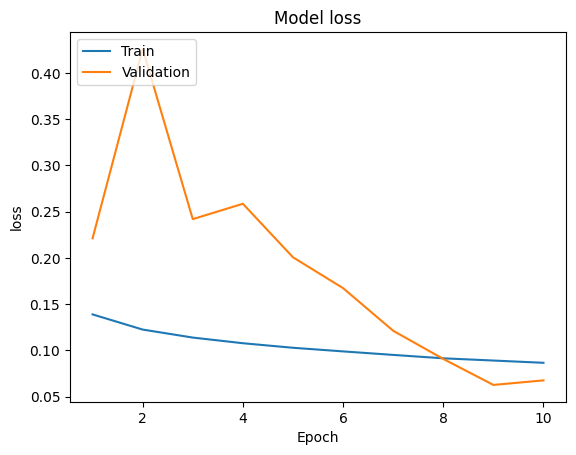

In [101]:
history_plot('loss')

## 6. Autoencoder

In [102]:
df_origin

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [103]:
df_origin['Time'] = StandardScaler().fit_transform(df_origin['Time'].values.reshape(-1, 1))
df_origin['Amount'] = StandardScaler().fit_transform(df_origin['Amount'].values.reshape(-1, 1))

In [104]:
border = int(len(df_origin)*0.9)
train = df_origin[:border]
test = df_origin[border:]

In [105]:
X_train_, y_train_ = split(train)
X_test_, y_test_ = split(test)

(256326, 30) (256326,)
(28481, 30) (28481,)


In [106]:
scaler = MinMaxScaler()
X_train_ = scaler.fit_transform(np.array(X_train_))
X_test_ = scaler.fit_transform(np.array(X_test_))

In [107]:
# data dimensions // hyperparameters 
INPUT_SHAPE = X_train_.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

In [108]:
input_dim = X_train_.shape[1]
encoding_dim = int(INPUT_SHAPE / 2) - 1
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-7

input_layer = Input(shape=(INPUT_SHAPE, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(INPUT_SHAPE, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)


In [109]:
autoencoder.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 14)                  │             434 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │             240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 835 (3.26 KB)

 Trainable params: 835 (3.26 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
autoencoder.compile(metrics=['accuracy','precision','recall'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [111]:
history = autoencoder.fit(X_train_, X_train_,
                    epochs=100,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(X_test_, X_test_),
                    verbose=1,
                    )

Epoch 1/100
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 3.5944e-04 - loss: 0.1164 - precision: 1.0000 - recall: 0.4576 - val_accuracy: 0.0032 - val_loss: 0.0884 - val_precision: 1.0000 - val_recall: 0.5136
Epoch 2/100
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 8.3962e-04 - loss: 0.0716 - precision: 1.0000 - recall: 0.5656 - val_accuracy: 0.1462 - val_loss: 0.0973 - val_precision: 1.0000 - val_recall: 0.5236
Epoch 3/100
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0015 - loss: 0.0618 - precision: 1.0000 - recall: 0.5977 - val_accuracy: 0.3176 - val_loss: 0.0801 - val_precision: 1.0000 - val_recall: 0.5531
Epoch 4/100
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.0015 - loss: 0.0466 - precision: 1.0000 - recall: 0.6231 - val_accuracy: 0.3156 - val_loss: 0.0824 - val_precision: 1.0000 - val_recall: 0.5502
Epoch 5/100
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0014 - loss: 0.0465 - precision: 1.0000 - recall: 0.6367 - val_accurac

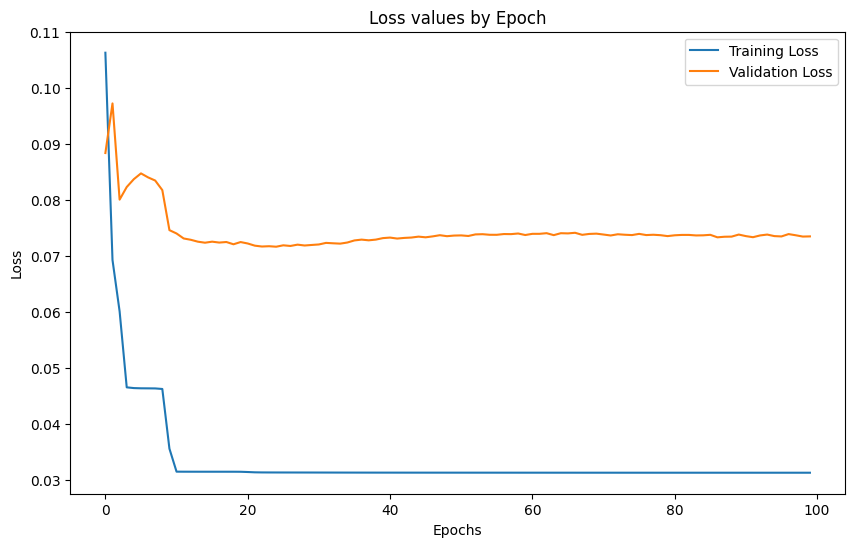

In [112]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

In [113]:
reconstructions = autoencoder.predict(X_test_, verbose=0)
reconstruction_error = mae(reconstructions, X_test_)

In [114]:
threshold = np.array(reconstruction_error).mean()
y_pred = list(map(lambda x: 1 if x>=threshold else 0, reconstruction_error))

In [115]:
print_metrix(y_test_,y_pred,reconstruction_error)

test-set confusion matrix:
 [[15352 13107]
 [   13     9]]
recall score:  0.4090909090909091
precision score:  0.0006861848124428179
f1 score:  0.0013700715481808495
accuracy score:  0.539342017485341
ROC AUC: 0.44361425847071867


In [116]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test_
}).reset_index(drop=True)
recons_df

,error,y_true
0,0.167359,0
1,0.186028,0
2,0.180854,0
3,0.183166,0
4,0.191328,0
...,...,...
28476,0.174636,0
28477,0.195253,0
28478,0.174307,0
28479,0.177322,0


In [117]:

from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix
def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(recons_df, 10)

Threshold: 0.1556	Accuracy: 0.001		Precision: 0.500	Recall Score: 0.500
Threshold: 0.1736	Accuracy: 0.100		Precision: 0.499	Recall Score: 0.436
Threshold: 0.1760	Accuracy: 0.200		Precision: 0.500	Recall Score: 0.464
Threshold: 0.1778	Accuracy: 0.300		Precision: 0.500	Recall Score: 0.445
Threshold: 0.1793	Accuracy: 0.400		Precision: 0.500	Recall Score: 0.427
Threshold: 0.1806	Accuracy: 0.500		Precision: 0.500	Recall Score: 0.455
Threshold: 0.1822	Accuracy: 0.600		Precision: 0.500	Recall Score: 0.482
Threshold: 0.1838	Accuracy: 0.700		Precision: 0.500	Recall Score: 0.486
Threshold: 0.1860	Accuracy: 0.800		Precision: 0.500	Recall Score: 0.491
Threshold: 0.1897	Accuracy: 0.899		Precision: 0.500	Recall Score: 0.518
